In [ ]:
"""
understanding the distribution of codes for each pilot study participant,
trying to understand how codes vary by participant
"""

In [1]:
import csv, json
from collections import Counter
import os, sys
sys.path.insert(0, '../db-processing')
import db_utils
from math import sqrt
from scipy import stats

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read ads for each user
user_ads_file = '../db-processing/user_ads_timestamps.tsv'
user_ads = {}
with open(user_ads_file, 'r') as fh:
    reader = csv.reader(fh, delimiter='\t')
    for line in reader:
        uid = line[0]
        # load the IDs, leaving out timestamps       
        ids = [x.split(',')[0] for x in line[1:]]        
        if len(ids):
            user_ads[uid] = ids

In [3]:
# read pilot ads coding
coding_file = '../pilot-ads-coding/angelica-coding.jsonl'
coding = {}
with open(coding_file, 'r') as fh:
    for line in fh:
        # TODO: also load ad text and index by code
        obj = json.loads(line)
        coding[obj['Ad ID']] = obj['label']
        
# also read user demographics
dems = db_utils.load_dem_file('../db-processing/prolific-demographics.csv')

# from: https://docs.google.com/document/d/1gpdew9ujr6i4VI1zH1FO0ylR3TUSCwJUIh-Xdu0lNZs/edit
high_ses = ['609471590c51b81087087049', '5df3ab425777b528cb364cde', '5d1ea7e579b687001af802c6']
low_ses = ['5bba226d70f8df0001c065f3', '5c6ac9e5d9c5be000174497f', '5e3cc28a194a520c0c128f13']

In [21]:
# which codes are not used?
from collections import Counter

codecounts = Counter()
for g in coding.values():
    for c in g:
        codecounts[c] += 1

print(codecounts)

Counter({'Benign': 601, 'Information': 79, 'Suspicious': 68, 'Revisit': 44, 'Opportunity': 39, 'Financial': 15, 'Potentially prohibited': 13, 'Political': 9, 'Potentially harmful': 1})


In [4]:
coding['23847898979880449']

['Suspicious']

In [11]:
# count user-level codes
user_codes = {}
allcodes = set()
for uid in user_ads:
    user_codes[uid] = Counter()
    for ad in user_ads[uid]:
        if ad in coding:
            # only 2 ads are missing
            for code in coding[ad]:
                user_codes[uid][code] += 1
                allcodes.add(code)
                
# move benign to start of list                
allcodes = list(allcodes)
allcodes.remove('Benign')
allcodes = ['Benign'] + allcodes

In [21]:
# what fraction of ads are benign, what fraction are harmful (suspicious+prohibited)
benign, harmful = 0, 0
for aid in coding:
    if 'Benign' in coding[aid]:
        benign += 1
    elif 'Suspicious' in coding[aid] or 'Potentially prohibited' in coding[aid]:
        harmful += 1
        
n = len(coding)
print(f'Benign: {benign}/{n} ({round(benign/n * 100, 2)}%); Harmful: {harmful}/{n} ({round(harmful/n * 100, 2)}%);)')

Benign: 601/746 (80.56%); Harmful: 73/746 (9.79%);)


In [11]:
# Question 1: what fraction of ads are not benign
pids = set(user_codes.keys()) - set(['5e1b299528c70235eeed62ef', '5c0fcccc1f6f150001487111'])
code_props = {}  # proportion for codes for each user
for p in pids:
    code_props[p] = [user_codes[p][c] for c in allcodes]
    code_props[p] = np.array(code_props[p]) / sum(code_props[p])

In [13]:
def normal_bin_conf(p, n, alpha=.95):
    tab = {0.90: 1.645, 0.95: 1.96, 0.99: 2.58}
    z = tab[alpha]
    # binomial proportion confidence interval
    return z * sqrt((p * (1-p))/n)

In [14]:
user_labels = {
    '609471590c51b81087087049': 'A',
    '5e3cc28a194a520c0c128f13': 'B',
    '5df3ab425777b528cb364cde': 'C',
    '5d1ea7e579b687001af802c6': 'D',
    '5c6ac9e5d9c5be000174497f': 'E',
    '5bba226d70f8df0001c065f3': 'F'
}

not benign, or info or political;	 suspicious+revisit
C: 1 					 0.5944055944055945
A: 32 					 0.5
D: 10 					 0.6470588235294118
F: 9 					 0.3333333333333333
E: 6 					 0.631578947368421
B: 2 					 0.6666666666666666


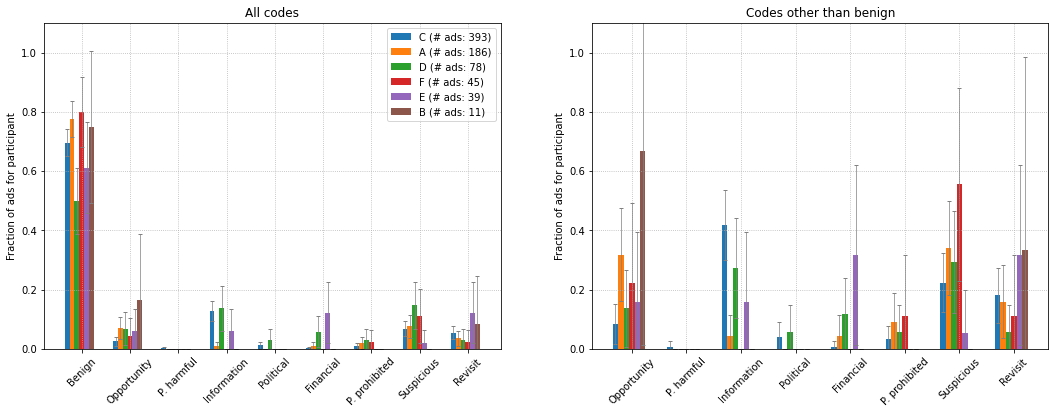

In [21]:
f, axs = plt.subplots(1, 2, figsize=(18, 6))

# only plotting the 6 users who gave multiple ads
offs = [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]
user_order = sorted(pids, key=lambda p: len(user_ads[p]), reverse=True)
print('not benign, or info or political;\t suspicious+revisit')
for i, p in enumerate(user_order):
    x = np.arange(len(code_props[p]))
    n = len(user_ads[p])
    errs = [normal_bin_conf(prop, n) for prop in code_props[p]]
    axs[0].bar(x + offs[i], code_props[p], 0.1, yerr=errs, capsize=2, lw=0,
           error_kw=dict(ecolor='grey', lw=.7),
           label=user_labels[p] + f' (# ads: {n})')
    
    # plot without benign ads in the second panel
    n -= user_codes[p]['Benign']    
    x = np.arange(len(code_props[p])-1)
    # only the interesting code props, benign is removed (on first ind of allcodes)
    code_props_int = [user_codes[p][c] for c in allcodes[1:]]
    code_props_int = np.array(code_props_int) / sum(code_props_int)
    print(f'{user_labels[p]}:', n-user_codes[p]['Information']-user_codes[p]['Political'],
          '\t\t\t\t\t', sum(code_props_int[:-2]))
    errs = [normal_bin_conf(prop, n) for prop in code_props_int]
    axs[1].bar(x + offs[i], code_props_int, 0.1, yerr=errs, capsize=2, lw=0,
              error_kw=dict(ecolor='grey', lw=.7),
              label=user_labels[p])
    
code_ticks = [x.replace('Potentially', 'P.') for x in allcodes]
axs[0].set_xticks(np.arange(len(code_props[p])))
axs[0].set_xticklabels(code_ticks, rotation=45)
axs[0].legend()
axs[0].set_title('All codes')

axs[1].set_title('Codes other than benign')
axs[1].set_xticks(np.arange(len(code_props[p]) - 1))
axs[1].set_xticklabels(code_ticks[1:], rotation=45)

for ax in axs:
    ax.set_ylim(bottom=0, top=1.1)
    ax.set_ylabel('Fraction of ads for participant')
    ax.grid(ls=':')

# plt.savefig('participant-code-distribution.jpg', dpi=200, bbox_inches='tight')

In [31]:
# TODO: observe fraction of non-benign, non-info ads by high/low SES
# harmful ads = prohibited + suspicious + hate
broadly_harmful = ['6265572946641', '6269895191441', '6269895209841', '23847549917010410',
        '23845251205600750', '23847571411330750', '23847689537720750', '23848273117330459',
       '23847586780210100', '23847949836880528', '6267697243641', '23848338693850343', '23848232246370343',
       '23848232246690343', '23848232246790343', '6242292113312', '23847984315350591', '23848191626470579']

labels = ['Low SES', 'High SES']
for i, cat in enumerate([low_ses, high_ses]):
    benign, harmful = 0, 0
    for uid in cat:
        for aid in user_ads[uid]:
            if aid not in coding:
                continue
            if aid in broadly_harmful or 'Suspicious' in coding[aid] or 'Potentially prohibited' in coding[aid]:
                harmful += 1
            else:
                benign += 1

    total = benign+harmful
    print(labels[i], '--', f'Benign: {benign}/{total} ({round(benign/total * 100, 2)}%)',
          f'Harmful: {harmful}/{total} ({round(harmful/total * 100, 2)}%)')

Low SES -- Benign: 81/95 (85.26%) Harmful: 14/95 (14.74%)
High SES -- Benign: 578/655 (88.24%) Harmful: 77/655 (11.76%)


In [34]:
# is the fraction of benign ads statistically significant across our pilot participants
con_tab = np.array([[user_codes[u]['Benign'], sum(user_codes[u].values()) - user_codes[u]['Benign']]\
                    for u in user_codes if u != '5e1b299528c70235eeed62ef'])
print(con_tab)

print('\ntest result (chi2, p-val):')
print(stats.chi2_contingency(con_tab)[:2])

[[ 30  19]
 [  9   3]
 [152  44]
 [ 36   9]
 [ 51  51]
 [326 143]]

test result (chi2, p-val):
(28.18386525918884, 3.350678148385569e-05)


**Quick Notes:**
- purple is probably the most interesting: only 50% ads are benign, and the rest are sketchy
- blue is getting more opportunity than the rest
- purple is getting more suspicious and information
- brown is getting more information than usual
- orange is getting more financial and "revisit" than the rest -- suggests risk
- also note only brown and purple saw political ads, not everyone on the platform is political
- everyone gets a little bit of potentially prohibited content, good job FB
(oh wow after ordering, the color has changed. previous purple is now green (D)

**Local Analysis (right panel):**
- minor insight: more clear now that red gets more suspicious ads compared to others


Perhaps, we can takeaway that D and E are seeing the most sketchy content, since more of their distribution skews towards non-"benign" ads. Can statistical tests help me confirm this hypothesis?

Also, it doesn't look like Angelica and I have consistent opinions for each code. Probably the only valuable opinion in this case would be the user's -- whatever we might think, if they are comfortable/actually happy to see an ad, who are we to judge. The simplest kind of harmful ad is the one that users themselves perceive as harmful.

In [ ]:
# next steps: solidify analysis
# can i say something more concrete through confidence intervals? DONE -- no i can't

# looks muddy. can i concretely say through statistical testing that there is a significant difference b/w our
# participants for opportunity ads, or suspicious ads? looks like a fairly simple proportion test...
# maybe an omnibus wrapped in somewhere

# can i say something using a more concise measure such as gini index?

In [ ]:
# MORE ANALYSES
# 1. is the proportion of benign+information different compare to the rest for any of these users? use tests to answer
# (ignore the political)

# 2. understand the volume of ads that are not benign+information+political -- how can we build a survey around 
# these to elicit user opinions? discuss these numbers with Angelica

In [ ]:
# is there some sort of harm score that can be given to each participant, such as fraction of suspicious and
# prohibited ads